In [38]:
import torch
import warnings
import shutil
from scripts import dog_breed
from torch.utils.data import Dataset, random_split, DataLoader
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
import os
from torchvision.datasets import ImageFolder
import shutil
%matplotlib inline
%load_ext autoreload
%autoreload 2
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dog

#### Train dataset curation

##### Load the data and filter the Stanford dataset

In [39]:
specified_breeds = ['beagle', 'border_collie', 'chihuahua', 'chow',
                    'cocker_spaniel', 'doberman', 'french_bulldog', 'giant_schnauzer', 'golden_retriever',
                    'great_dane', 'labrador_retriever', 'malinois', 'maltese_dog', 'pekinese', 'pug', 'rottweiler',
                    'saint_bernard', 'samoyed', 'shih-tzu', 'siberian_husky', 'toy_poodle', 'west_highland_white_terrier', 'yorkshire_terrier']


In [40]:
source_folder = 'stanford_dogs/images/Images/'
target_folder = 'filter_dog/train'

if not os.path.exists(target_folder):
    os.makedirs(target_folder)

dataset = ImageFolder(root=source_folder)

for idx, (image_path, label) in enumerate(dataset.imgs):
    breed_name = dataset.classes[label].split('-', 1)[-1].lower()
    if breed_name in specified_breeds:
        breed_folder = os.path.join(target_folder, breed_name)
        if not os.path.exists(breed_folder):
            os.makedirs(breed_folder)
        shutil.copy(image_path, breed_folder)

In [41]:
dataset = ImageFolder('filter_dog/train/')

In [42]:
all_breeds = dataset.classes

print("Total number of breeds:", len(all_breeds))
print("List of all breeds:")
print(all_breeds)

Total number of breeds: 23
List of all breeds:
['beagle', 'border_collie', 'chihuahua', 'chow', 'cocker_spaniel', 'doberman', 'french_bulldog', 'giant_schnauzer', 'golden_retriever', 'great_dane', 'labrador_retriever', 'malinois', 'maltese_dog', 'pekinese', 'pug', 'rottweiler', 'saint_bernard', 'samoyed', 'shih-tzu', 'siberian_husky', 'toy_poodle', 'west_highland_white_terrier', 'yorkshire_terrier']


In [43]:
test_pct = 0.3
test_size = int(len(dataset)*test_pct)
dataset_size = len(dataset) - test_size
train_size = dataset_size

train_size,  test_size

(2784, 1192)

In [44]:
breeds = []

def rename(name):
    return name.split('-', 1)[-1].lower()

for n in dataset.classes:
    breeds.append(rename(n))

In [45]:
breeds

['beagle',
 'border_collie',
 'chihuahua',
 'chow',
 'cocker_spaniel',
 'doberman',
 'french_bulldog',
 'giant_schnauzer',
 'golden_retriever',
 'great_dane',
 'labrador_retriever',
 'malinois',
 'maltese_dog',
 'pekinese',
 'pug',
 'rottweiler',
 'saint_bernard',
 'samoyed',
 'tzu',
 'siberian_husky',
 'toy_poodle',
 'west_highland_white_terrier',
 'yorkshire_terrier']

In [46]:
train_ds,  test_ds = random_split(dataset, [train_size, test_size])
len(train_ds), len(test_ds)

(2784, 1192)

In [47]:
train_ds[0]

(<PIL.Image.Image image mode=RGB size=333x500>, 6)

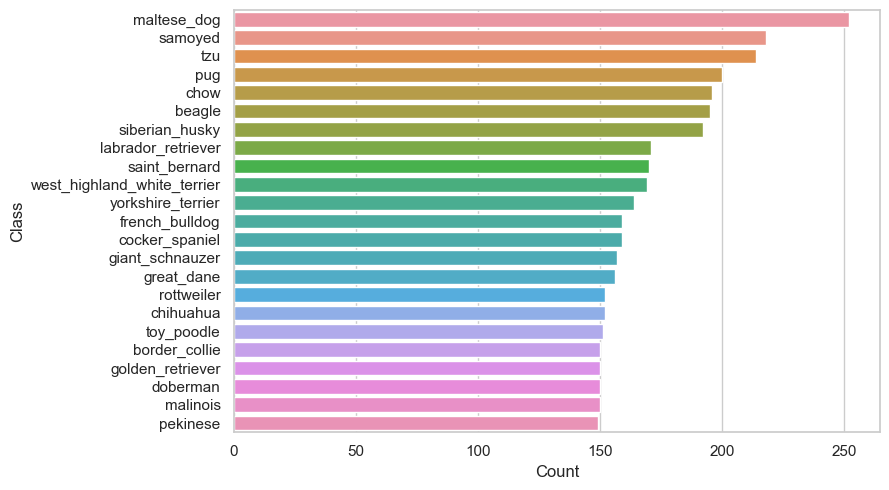

In [48]:
class_names = breeds
class_count = [dataset.targets.count(i) for i in range(len(class_names))]
df = pd.DataFrame({"Class": class_names, "Count": class_count}).sort_values(by='Count', ascending=False)

plt.figure(figsize=(9,5), dpi=100)
sns.barplot(x="Count", y="Class", data=df)
plt.tight_layout()
plt.show()

##### DataLoader

In [49]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
])

In [50]:
train_dataset = dog_breed.DogBreedDataset(train_ds, train_transform)
test_dataset = dog_breed.DogBreedDataset(test_ds, test_transform)

batch_size = 16

train_dl = DataLoader(train_dataset, batch_size, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size*2)

13


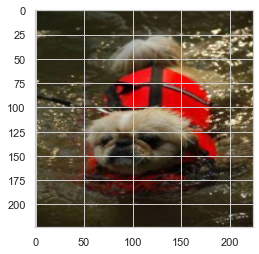

In [51]:
img, label = train_dataset[6]
print(label)
plt.imshow(img.permute(1,2,0))

##### Train loop

In [52]:
models_list = ["resnet18", "alexnet", "vgg19bn", "densenet", "mobilenetv3"]
for model_name in models_list:
    num_classes = len(all_breeds)
    model = dog_breed.get_pretrained_model(model_name, num_classes)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.99), eps=1e-08, weight_decay=1e-5)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    train, eval = dog_breed.train_and_test(model, model_name, train_dl, test_dl, criterion, optimizer, device, num_epochs=15, type='dog')

    os.makedirs("breed_models/dog", exist_ok=True)
    model_filename = f"breed_models/dog/{model_name}_best_model.pth"
    torch.save(model.state_dict(), model_filename)

Epoch 1/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 1.5829 Acc: 0.6002
Test Loss: 0.7084 Acc: 0.8498
Epoch 2/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.6247 Acc: 0.8531
Test Loss: 0.4742 Acc: 0.8767
Epoch 3/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.4570 Acc: 0.8843
Test Loss: 0.4382 Acc: 0.8666
Epoch 4/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.3863 Acc: 0.8908
Test Loss: 0.3813 Acc: 0.8884
Epoch 5/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.3267 Acc: 0.9045
Test Loss: 0.3820 Acc: 0.8842
Epoch 6/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.2832 Acc: 0.9170
Test Loss: 0.3892 Acc: 0.8775
Epoch 7/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.2722 Acc: 0.9177
Test Loss: 0.3626 Acc: 0.8767
Epoch 8/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.2494 Acc: 0.9253
Test Loss: 0.3559 Acc: 0.8926
Epoch 9/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.2245 Acc: 0.9249
Test Loss: 0.3771 Acc: 0.8817
Epoch 10/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.2400 Acc: 0.9267
Test Loss: 0.3686 Acc: 0.8792
Epoch 11/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.2126 Acc: 0.9364
Test Loss: 0.4062 Acc: 0.8725
Epoch 12/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.1946 Acc: 0.9415
Test Loss: 0.3733 Acc: 0.8876
Epoch 13/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.1806 Acc: 0.9454
Test Loss: 0.3829 Acc: 0.8800
Epoch 14/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.1683 Acc: 0.9468
Test Loss: 0.3746 Acc: 0.8893
Epoch 15/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.1842 Acc: 0.9429
Test Loss: 0.4246 Acc: 0.8691
Epoch 1/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 2.0652 Acc: 0.3987
Test Loss: 1.5918 Acc: 0.5243
Epoch 2/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 1.3099 Acc: 0.5973
Test Loss: 1.5643 Acc: 0.5285
Epoch 3/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 1.1158 Acc: 0.6408
Test Loss: 1.7045 Acc: 0.5185
Epoch 4/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.9651 Acc: 0.6850
Test Loss: 1.6482 Acc: 0.5545
Epoch 5/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.8646 Acc: 0.7108
Test Loss: 1.5685 Acc: 0.5738
Epoch 6/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.8035 Acc: 0.7284
Test Loss: 1.6504 Acc: 0.5570
Epoch 7/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.6951 Acc: 0.7640
Test Loss: 1.7805 Acc: 0.5361
Epoch 8/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.6447 Acc: 0.7816
Test Loss: 1.8145 Acc: 0.5453
Epoch 9/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.6334 Acc: 0.7863
Test Loss: 1.8268 Acc: 0.5344
Epoch 10/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.6019 Acc: 0.7974
Test Loss: 1.9134 Acc: 0.5470
Epoch 11/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.5555 Acc: 0.8085
Test Loss: 1.9118 Acc: 0.5411
Epoch 12/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.5571 Acc: 0.8125
Test Loss: 2.0026 Acc: 0.5378
Epoch 13/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.5147 Acc: 0.8276
Test Loss: 1.9686 Acc: 0.5403
Epoch 14/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.4850 Acc: 0.8323
Test Loss: 1.9591 Acc: 0.5512
Epoch 15/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.4698 Acc: 0.8409
Test Loss: 1.9321 Acc: 0.5369
Epoch 1/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.5236 Acc: 0.8445
Test Loss: 0.2344 Acc: 0.9371
Epoch 2/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.2095 Acc: 0.9371
Test Loss: 0.2402 Acc: 0.9237
Epoch 3/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.1821 Acc: 0.9368
Test Loss: 0.2357 Acc: 0.9237
Epoch 4/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.1512 Acc: 0.9465
Test Loss: 0.2822 Acc: 0.9161
Epoch 5/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.1294 Acc: 0.9547
Test Loss: 0.2422 Acc: 0.9329
Epoch 6/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.1276 Acc: 0.9511
Test Loss: 0.2643 Acc: 0.9287
Epoch 7/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.1148 Acc: 0.9612
Test Loss: 0.2458 Acc: 0.9337
Epoch 8/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.1087 Acc: 0.9619
Test Loss: 0.2747 Acc: 0.9279
Epoch 9/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.1081 Acc: 0.9637
Test Loss: 0.2905 Acc: 0.9312
Epoch 10/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.0916 Acc: 0.9630
Test Loss: 0.2452 Acc: 0.9354
Epoch 11/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.0997 Acc: 0.9670
Test Loss: 0.2778 Acc: 0.9279
Epoch 12/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.0944 Acc: 0.9655
Test Loss: 0.3101 Acc: 0.9270
Epoch 13/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.1028 Acc: 0.9644
Test Loss: 0.2837 Acc: 0.9354
Epoch 14/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.0850 Acc: 0.9705
Test Loss: 0.3217 Acc: 0.9270
Epoch 15/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.0964 Acc: 0.9677
Test Loss: 0.3020 Acc: 0.9304
Epoch 1/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 1.4154 Acc: 0.6943
Test Loss: 0.5411 Acc: 0.9119
Epoch 2/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.4775 Acc: 0.8962
Test Loss: 0.3384 Acc: 0.9237
Epoch 3/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.3384 Acc: 0.9170
Test Loss: 0.2898 Acc: 0.9161
Epoch 4/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.2608 Acc: 0.9325
Test Loss: 0.2576 Acc: 0.9329
Epoch 5/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.2247 Acc: 0.9364
Test Loss: 0.2564 Acc: 0.9329
Epoch 6/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.2084 Acc: 0.9371
Test Loss: 0.2622 Acc: 0.9203
Epoch 7/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.1781 Acc: 0.9476
Test Loss: 0.2410 Acc: 0.9262
Epoch 8/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.1443 Acc: 0.9573
Test Loss: 0.2287 Acc: 0.9270
Epoch 9/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.1609 Acc: 0.9547
Test Loss: 0.2389 Acc: 0.9253
Epoch 10/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.1282 Acc: 0.9641
Test Loss: 0.2475 Acc: 0.9287
Epoch 11/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.1279 Acc: 0.9591
Test Loss: 0.2192 Acc: 0.9354
Epoch 12/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.1158 Acc: 0.9666
Test Loss: 0.2336 Acc: 0.9279
Epoch 13/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.1051 Acc: 0.9662
Test Loss: 0.2440 Acc: 0.9237
Epoch 14/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.1156 Acc: 0.9677
Test Loss: 0.2413 Acc: 0.9329
Epoch 15/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.0880 Acc: 0.9756
Test Loss: 0.2370 Acc: 0.9304
Epoch 1/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 1.5701 Acc: 0.6221
Test Loss: 1.0535 Acc: 0.7198
Epoch 2/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.7073 Acc: 0.8247
Test Loss: 0.6834 Acc: 0.8070
Epoch 3/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.5146 Acc: 0.8693
Test Loss: 0.5846 Acc: 0.8238
Epoch 4/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.4021 Acc: 0.8966
Test Loss: 0.5664 Acc: 0.8247
Epoch 5/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.3334 Acc: 0.9167
Test Loss: 0.5590 Acc: 0.8314
Epoch 6/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.3027 Acc: 0.9213
Test Loss: 0.5629 Acc: 0.8238
Epoch 7/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.2619 Acc: 0.9375
Test Loss: 0.5640 Acc: 0.8238
Epoch 8/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.2371 Acc: 0.9411
Test Loss: 0.5660 Acc: 0.8280
Epoch 9/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.1968 Acc: 0.9501
Test Loss: 0.5711 Acc: 0.8230
Epoch 10/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.1969 Acc: 0.9508
Test Loss: 0.5634 Acc: 0.8263
Epoch 11/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.1769 Acc: 0.9529
Test Loss: 0.5727 Acc: 0.8180
Epoch 12/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.1703 Acc: 0.9591
Test Loss: 0.5778 Acc: 0.8230
Epoch 13/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.1462 Acc: 0.9680
Test Loss: 0.5765 Acc: 0.8263
Epoch 14/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.1553 Acc: 0.9641
Test Loss: 0.5813 Acc: 0.8196
Epoch 15/15


  0%|          | 0/174 [00:00<?, ?it/s]

Train Loss: 0.1325 Acc: 0.9659
Test Loss: 0.6050 Acc: 0.8171


In [53]:
model_accuracies_dict, model_test_accuracies_dict, model_losses_dict, last_true_labels, last_model_preds, model_names = dog_breed.load_the_results(type='dog')

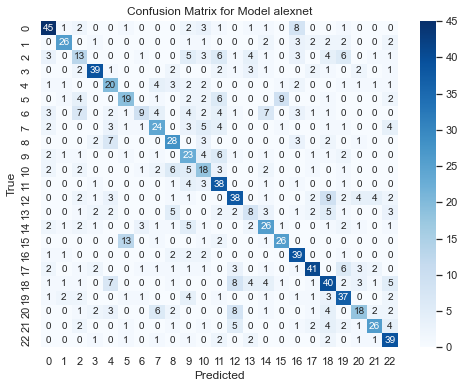

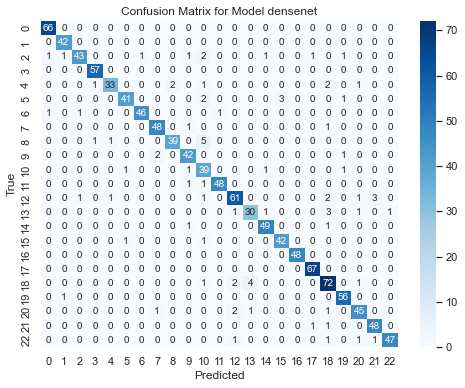

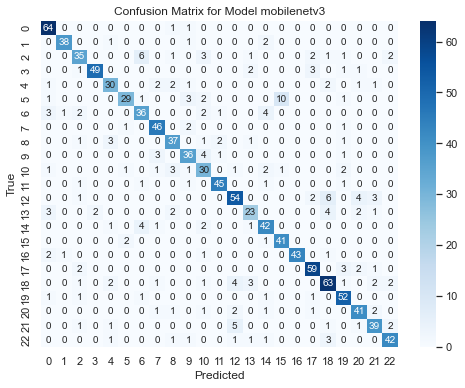

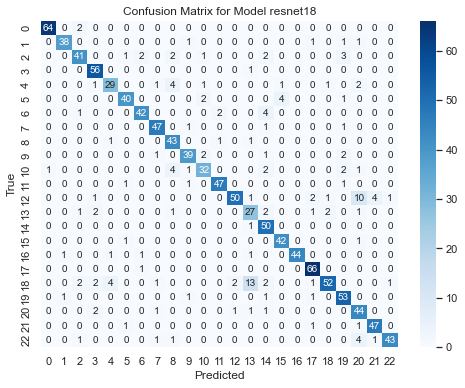

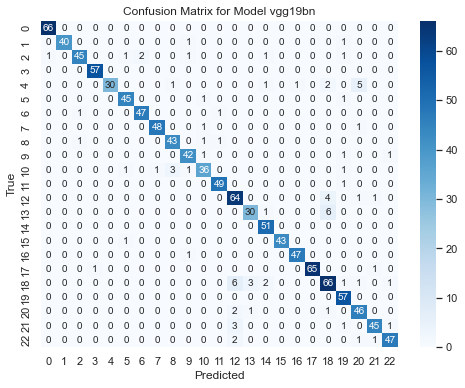

In [54]:
confusion_matrices = []

for true_labels, model_preds in zip(last_true_labels, last_model_preds):
    cm = confusion_matrix(true_labels, model_preds)
    confusion_matrices.append(cm)

for i, cm in enumerate(confusion_matrices):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', 
                xticklabels=np.unique(last_true_labels[i]), 
                yticklabels=np.unique(last_true_labels[i]))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for Model {model_names[i]}')
    plt.show()


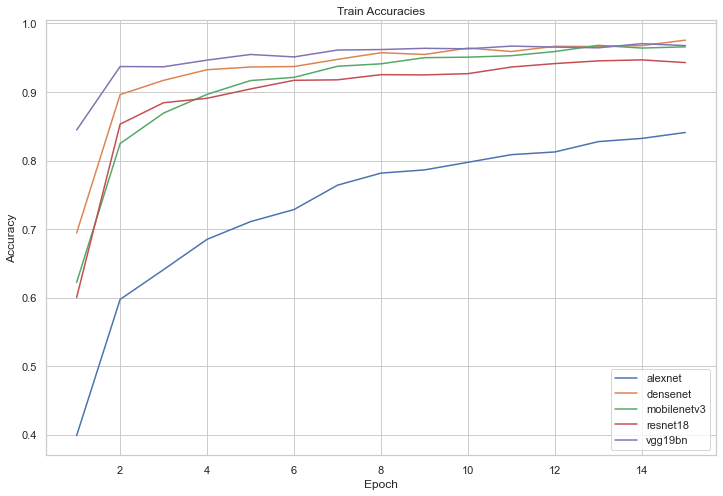

In [55]:
plt.figure(figsize=(12, 8))

for model, accuracies in model_accuracies_dict.items():
    plt.plot(range(1, len(accuracies) + 1), accuracies, label=model)

plt.title('Train Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

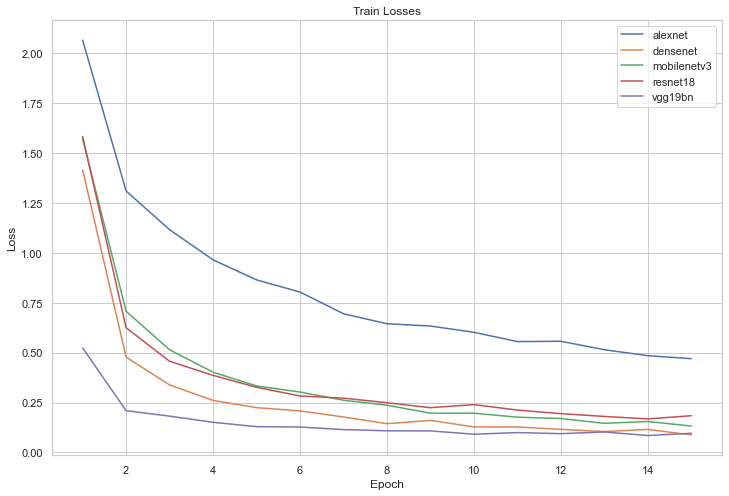

In [56]:
plt.figure(figsize=(12, 8))

for model, accuracies in model_losses_dict.items():
    
    plt.plot(range(1, len(accuracies) + 1), accuracies, label=model)

plt.title('Train Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

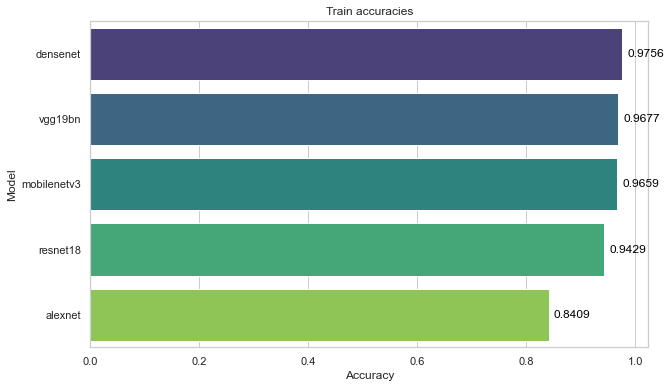

In [57]:
last_accuracies = [accuracies[-1] for accuracies in model_accuracies_dict.values()]
models = list(model_accuracies_dict.keys())

sorted_data = sorted(zip(last_accuracies, models), reverse=True)
sorted_accuracies, sorted_models = zip(*sorted_data)

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

ax = sns.barplot(x=list(sorted_accuracies), y=list(sorted_models), palette='viridis')

for i, v in enumerate(sorted_accuracies):
    ax.text(v + 0.01, i, f'{v:.4f}', color='black', va='center')

plt.title('Train accuracies')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.show()


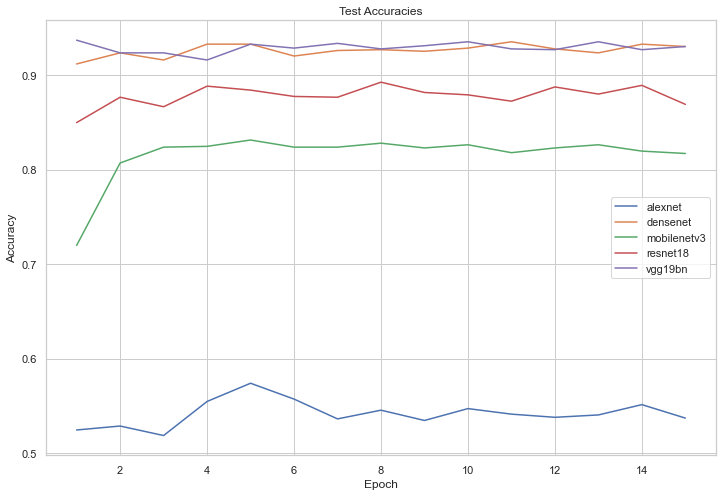

In [58]:
plt.figure(figsize=(12, 8))

for model, accuracies in model_test_accuracies_dict.items():
    plt.plot(range(1, len(accuracies) + 1), accuracies, label=model)

plt.title('Test Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

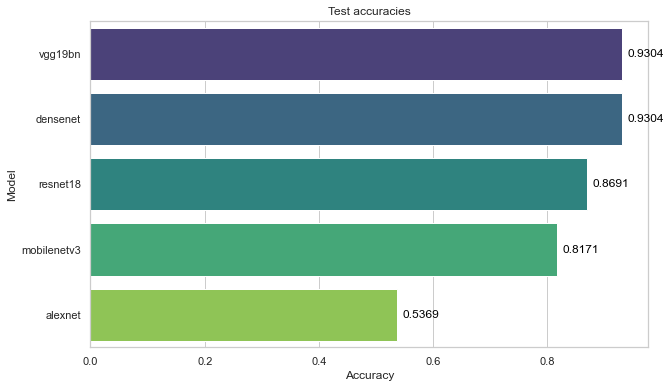

In [59]:
last_accuracies = [accuracies[-1] for accuracies in model_test_accuracies_dict.values()]
models = list(model_test_accuracies_dict.keys())

sorted_data = sorted(zip(last_accuracies, models), reverse=True)
sorted_accuracies, sorted_models = zip(*sorted_data)

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

ax = sns.barplot(x=list(sorted_accuracies), y=list(sorted_models), palette='viridis')

for i, v in enumerate(sorted_accuracies):
    ax.text(v + 0.01, i, f'{v:.4f}', color='black', va='center')

plt.title('Test accuracies')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.show()


In [60]:
len(breeds)

23

##### Scrapped test dog dataset

In [65]:
specified_breeds = ['beagle', 'border_collie', 'chihuahua', 'chow',
                    'cocker_spaniel', 'doberman', 'french_bulldog', 'giant_schnauzer', 'golden_retriever',
                    'great_dane', 'labrador_retriever', 'malinois', 'maltese_dog', 'pekinese', 'pug', 'rottweiler',
                    'saint_bernard', 'samoyed', 'shih_tzu', 'siberian_husky', 'toy_poodle', 'west_highland_white_terrier', 'yorkshire_terrier']


In [66]:
results_directory = f'breed_models/dog/'
all_files = os.listdir(results_directory)
model_files = [file for file in all_files if file.endswith('.pth')]
model_names = [file.split('_')[0] for file in model_files]

In [67]:
source_folder = 'breed_dataset/dog/'
target_folder = 'filter_dog/test'

if not os.path.exists(target_folder):
    os.makedirs(target_folder)

dataset = ImageFolder(root=source_folder)

for idx, (image_path, label) in enumerate(dataset.imgs):
    breed_name = dataset.classes[label].split('-', 1)[-1].lower()
    if breed_name in specified_breeds:
        breed_folder = os.path.join(target_folder, breed_name)
        if not os.path.exists(breed_folder):
            os.makedirs(breed_folder)
        shutil.copy(image_path, breed_folder)

  0%|          | 0/88 [00:00<?, ?it/s]

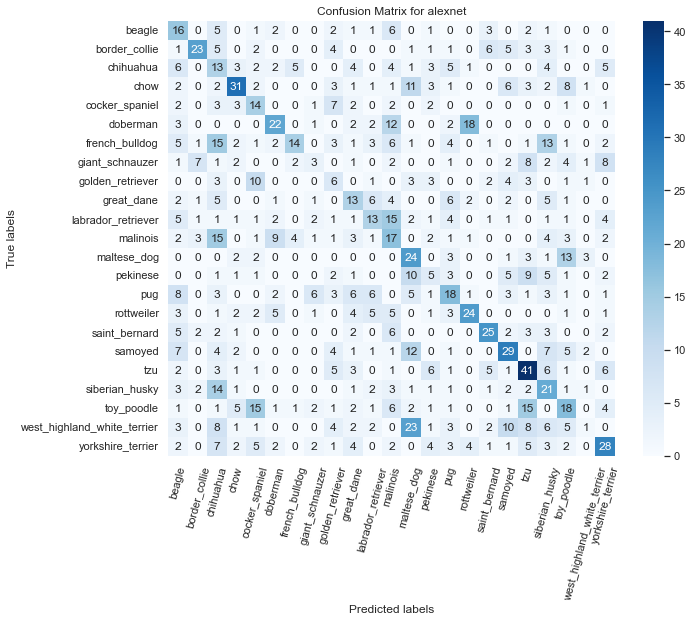

Accuracy: 29.99%


  0%|          | 0/88 [00:00<?, ?it/s]

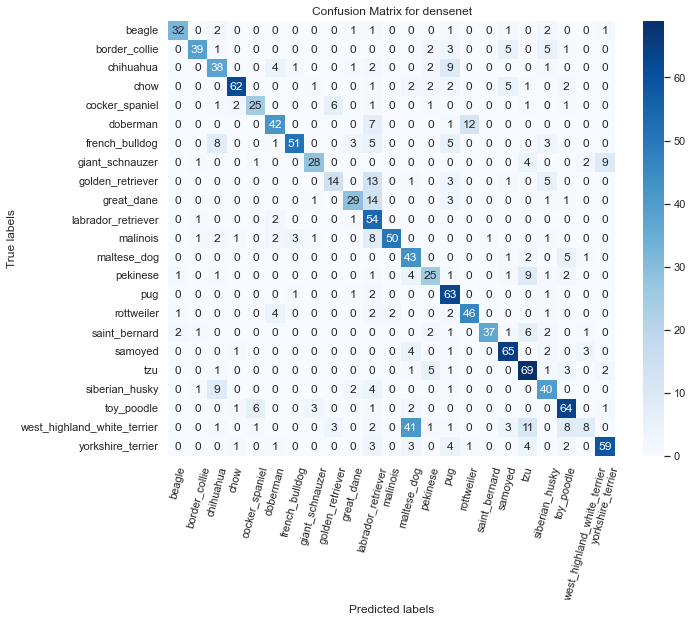

Accuracy: 70.37%


  0%|          | 0/88 [00:00<?, ?it/s]

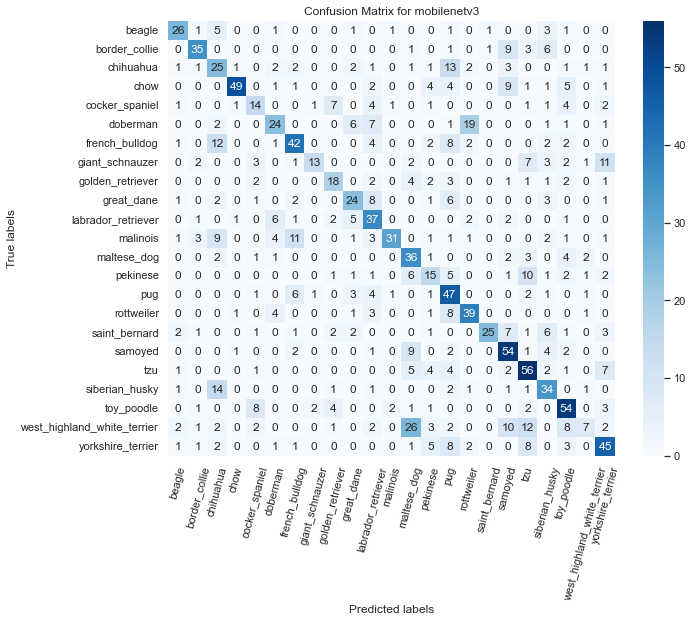

Accuracy: 53.69%


  0%|          | 0/88 [00:00<?, ?it/s]

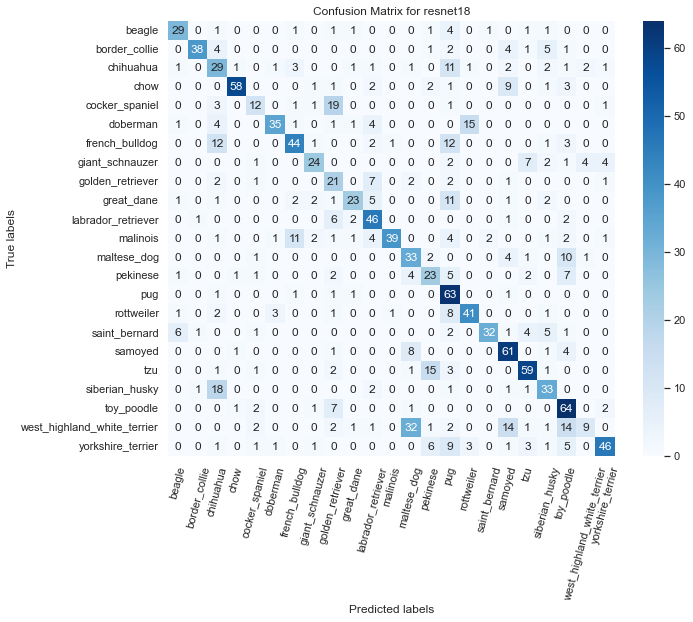

Accuracy: 61.70%


  0%|          | 0/88 [00:00<?, ?it/s]

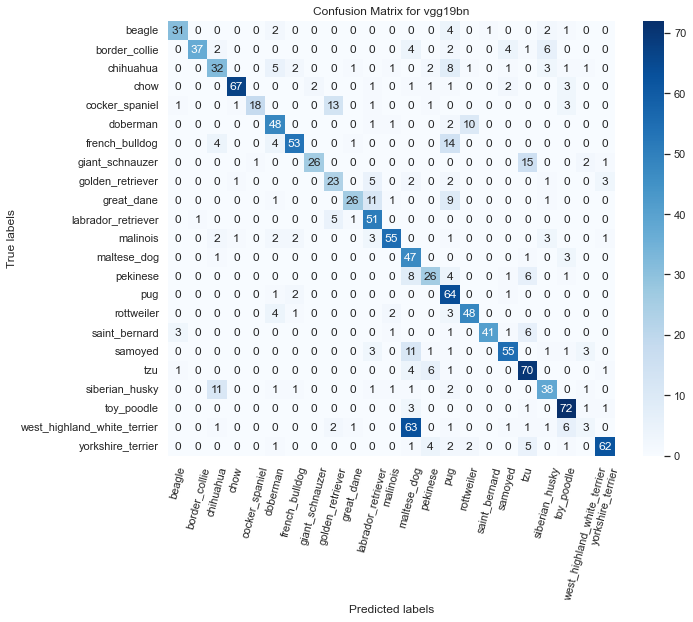

Accuracy: 71.08%


In [68]:
test_data_scrap_cat = ImageFolder('filter_dog/test/')
test_transform = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
])
accuracies_scrap = {}
for model_name in model_names:
    state_dict = torch.load(f"breed_models/dog/{model_name}_best_model.pth")
    model = dog_breed.get_pretrained_model(model_name, len(breeds))

    model.load_state_dict(state_dict)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    batch_size = 8
    test_dataset_scrap = dog_breed.CatBreedDataset(test_data_scrap_cat, test_transform)
    test_dl_scrap = DataLoader(test_dataset_scrap, batch_size*2)

    confusion_matrix_all_classes = dog_breed.create_confusion_matrix(model, test_dl_scrap)
    dog_breed.plot_confusion_matrix(confusion_matrix_all_classes, breeds, model_name)
    
    total_samples = len(test_dataset_scrap)
    correct_predictions = sum(confusion_matrix_all_classes[i][i] for i in range(len(confusion_matrix_all_classes)))
    accuracy = correct_predictions / total_samples
    accuracies_scrap[model_name] = accuracy
    print(f"Accuracy: {accuracy * 100:.2f}%")



## Cat

### Training

#### Mental illnesses

In [69]:
class_names = [
    'abyssinian', 'bengal', 'bombay',
    'british_shorthair', 'maine_coon', 'persian',
    'ragdoll', 'russian_blue', 'siamese', 'sphynx'
]

data_dir = 'oxford-iiit-pet/images/images/'

output_dir = 'filter_cat'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for class_name in class_names:
    class_dir = os.path.join(output_dir, class_name)
    if not os.path.exists(class_dir):
        os.makedirs(class_dir)

for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith('.jpg'):
            for class_name in class_names:
                if class_name.lower() in file.lower():
                    src_path = os.path.join(root, file)
                    dst_path = os.path.join(output_dir, class_name, file)
                    shutil.copy(src_path, dst_path)
                    break 


In [70]:
dataset = ImageFolder('filter_cat/')

In [72]:
all_breeds = dataset.classes

print("Total number of breeds:", len(all_breeds))
print("List of all breeds:")
print(all_breeds)

Total number of breeds: 10
List of all breeds:
['abyssinian', 'bengal', 'bombay', 'british_shorthair', 'maine_coon', 'persian', 'ragdoll', 'russian_blue', 'siamese', 'sphynx']


In [73]:
test_pct = 0.3
test_size = int(len(dataset)*test_pct)
dataset_size = len(dataset) - test_size
train_size = dataset_size

train_size,  test_size

(1400, 600)

In [74]:
train_ds_cat, test_ds_cat = random_split(dataset, [train_size, test_size])
len(train_ds_cat), len(test_ds_cat)

(1400, 600)

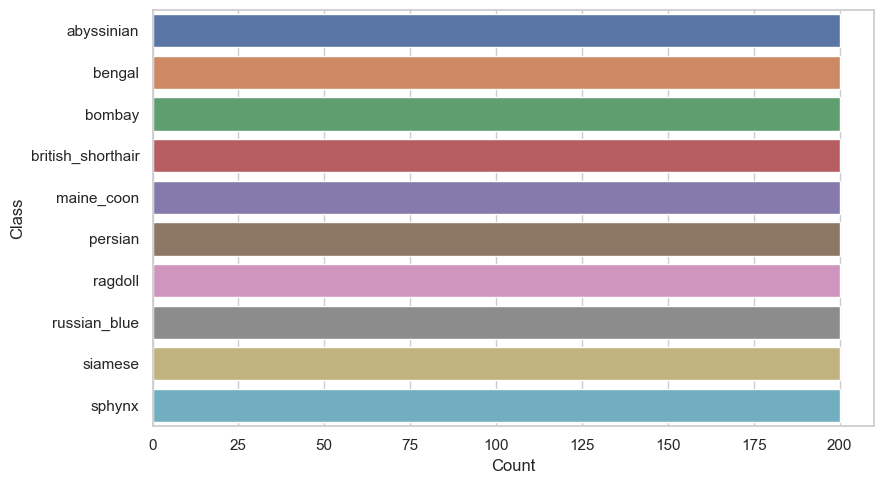

In [75]:
class_names = all_breeds
class_count = [dataset.targets.count(i) for i in range(len(class_names))]
df = pd.DataFrame({"Class": class_names, "Count": class_count}).sort_values(by='Count', ascending=False)

plt.figure(figsize=(9,5), dpi=100)
sns.barplot(x="Count", y="Class", data=df)
plt.tight_layout()
plt.show()

In [76]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
])

In [77]:
train_dataset = dog_breed.DogBreedDataset(train_ds_cat, train_transform)
test_dataset = dog_breed.DogBreedDataset(test_ds_cat, test_transform)

batch_size = 16

train_dl_cat = DataLoader(train_dataset, batch_size, shuffle=True)
test_dl_cat = DataLoader(test_dataset, batch_size*2)

1


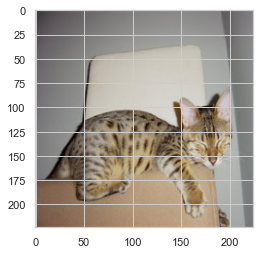

In [78]:
img, label = train_dataset[11]
print(label)
plt.imshow(img.permute(1,2,0))

#### Actual training

In [79]:
models_list = ["resnet18", "alexnet", "vgg19bn", "densenet", "mobilenetv3"]
for model_name in models_list:
    num_classes = len(all_breeds)
    model = dog_breed.get_pretrained_model(model_name, num_classes)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.99), eps=1e-08, weight_decay=1e-5)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    train, eval = dog_breed.train_and_test(model, model_name, train_dl_cat, test_dl_cat, criterion, optimizer, device, num_epochs=15, type='cat')

    os.makedirs("breed_models/cat/", exist_ok=True)
    model_filename = f"breed_models/cat/{model_name}_best_model.pth"
    torch.save(model.state_dict(), model_filename)

Epoch 1/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 1.4482 Acc: 0.5836
Test Loss: 0.7867 Acc: 0.8317
Epoch 2/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.6965 Acc: 0.8457
Test Loss: 0.5319 Acc: 0.8617
Epoch 3/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.5453 Acc: 0.8571
Test Loss: 0.4539 Acc: 0.8567
Epoch 4/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.4435 Acc: 0.8829
Test Loss: 0.4340 Acc: 0.8550
Epoch 5/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.3925 Acc: 0.8893
Test Loss: 0.3723 Acc: 0.8700
Epoch 6/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.3315 Acc: 0.9050
Test Loss: 0.3653 Acc: 0.8750
Epoch 7/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.3041 Acc: 0.9114
Test Loss: 0.3269 Acc: 0.8850
Epoch 8/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.2925 Acc: 0.9250
Test Loss: 0.3734 Acc: 0.8750
Epoch 9/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.2899 Acc: 0.9157
Test Loss: 0.3329 Acc: 0.8683
Epoch 10/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.2465 Acc: 0.9314
Test Loss: 0.3276 Acc: 0.8817
Epoch 11/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.2597 Acc: 0.9193
Test Loss: 0.3333 Acc: 0.8700
Epoch 12/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.2236 Acc: 0.9307
Test Loss: 0.3296 Acc: 0.8800
Epoch 13/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.2181 Acc: 0.9343
Test Loss: 0.3388 Acc: 0.8750
Epoch 14/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.2093 Acc: 0.9450
Test Loss: 0.3149 Acc: 0.8733
Epoch 15/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.1973 Acc: 0.9414
Test Loss: 0.3206 Acc: 0.8900
Epoch 1/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 1.4324 Acc: 0.5057
Test Loss: 1.0259 Acc: 0.6283
Epoch 2/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.8254 Acc: 0.7129
Test Loss: 0.8950 Acc: 0.6817
Epoch 3/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.7137 Acc: 0.7507
Test Loss: 0.9174 Acc: 0.6783
Epoch 4/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.6380 Acc: 0.7707
Test Loss: 0.9276 Acc: 0.6783
Epoch 5/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.5817 Acc: 0.7907
Test Loss: 0.8883 Acc: 0.6850
Epoch 6/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.5097 Acc: 0.8236
Test Loss: 0.9348 Acc: 0.7000
Epoch 7/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.5234 Acc: 0.8086
Test Loss: 0.9455 Acc: 0.6933
Epoch 8/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.4788 Acc: 0.8293
Test Loss: 0.9927 Acc: 0.6833
Epoch 9/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.4327 Acc: 0.8471
Test Loss: 1.0757 Acc: 0.6633
Epoch 10/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.3926 Acc: 0.8593
Test Loss: 0.9902 Acc: 0.6950
Epoch 11/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.3569 Acc: 0.8814
Test Loss: 0.9479 Acc: 0.7083
Epoch 12/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.3856 Acc: 0.8607
Test Loss: 1.0277 Acc: 0.6900
Epoch 13/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.3603 Acc: 0.8757
Test Loss: 1.0442 Acc: 0.6717
Epoch 14/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.3549 Acc: 0.8821
Test Loss: 1.0344 Acc: 0.6733
Epoch 15/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.3411 Acc: 0.8764
Test Loss: 1.1018 Acc: 0.6800
Epoch 1/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.7576 Acc: 0.7500
Test Loss: 0.3394 Acc: 0.8950
Epoch 2/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.3675 Acc: 0.8657
Test Loss: 0.3146 Acc: 0.8850
Epoch 3/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.2885 Acc: 0.9014
Test Loss: 0.3085 Acc: 0.8850
Epoch 4/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.2659 Acc: 0.9057
Test Loss: 0.3008 Acc: 0.8917
Epoch 5/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.2659 Acc: 0.9014
Test Loss: 0.2932 Acc: 0.8833
Epoch 6/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.2353 Acc: 0.9086
Test Loss: 0.2883 Acc: 0.8883
Epoch 7/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.2204 Acc: 0.9329
Test Loss: 0.2886 Acc: 0.8983
Epoch 8/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.2033 Acc: 0.9264
Test Loss: 0.3116 Acc: 0.8833
Epoch 9/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.2077 Acc: 0.9229
Test Loss: 0.3035 Acc: 0.8883
Epoch 10/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.1997 Acc: 0.9264
Test Loss: 0.3069 Acc: 0.8917
Epoch 11/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.1586 Acc: 0.9343
Test Loss: 0.3249 Acc: 0.8967
Epoch 12/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.1703 Acc: 0.9429
Test Loss: 0.3180 Acc: 0.8883
Epoch 13/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.1730 Acc: 0.9329
Test Loss: 0.3134 Acc: 0.8917
Epoch 14/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.1821 Acc: 0.9307
Test Loss: 0.3084 Acc: 0.8967
Epoch 15/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.1769 Acc: 0.9243
Test Loss: 0.3255 Acc: 0.8833
Epoch 1/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 1.3776 Acc: 0.6121
Test Loss: 0.7746 Acc: 0.8050
Epoch 2/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.6522 Acc: 0.8564
Test Loss: 0.4859 Acc: 0.8817
Epoch 3/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.4492 Acc: 0.8964
Test Loss: 0.3804 Acc: 0.8967
Epoch 4/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.3668 Acc: 0.8957
Test Loss: 0.3574 Acc: 0.8983
Epoch 5/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.3216 Acc: 0.9114
Test Loss: 0.3064 Acc: 0.9167
Epoch 6/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.2525 Acc: 0.9386
Test Loss: 0.2926 Acc: 0.9083
Epoch 7/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.2495 Acc: 0.9371
Test Loss: 0.3403 Acc: 0.8933
Epoch 8/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.2262 Acc: 0.9371
Test Loss: 0.2710 Acc: 0.9067
Epoch 9/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.2084 Acc: 0.9507
Test Loss: 0.2608 Acc: 0.9117
Epoch 10/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.1647 Acc: 0.9593
Test Loss: 0.2693 Acc: 0.9083
Epoch 11/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.1815 Acc: 0.9457
Test Loss: 0.2569 Acc: 0.9117
Epoch 12/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.1795 Acc: 0.9493
Test Loss: 0.2468 Acc: 0.9100
Epoch 13/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.1580 Acc: 0.9571
Test Loss: 0.2418 Acc: 0.9150
Epoch 14/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.1636 Acc: 0.9421
Test Loss: 0.2425 Acc: 0.9100
Epoch 15/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.1372 Acc: 0.9686
Test Loss: 0.2589 Acc: 0.9067
Epoch 1/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 1.2441 Acc: 0.6600
Test Loss: 0.6432 Acc: 0.8400
Epoch 2/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.5628 Acc: 0.8607
Test Loss: 0.6789 Acc: 0.7783
Epoch 3/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.4132 Acc: 0.8907
Test Loss: 0.5408 Acc: 0.8167
Epoch 4/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.3285 Acc: 0.9121
Test Loss: 0.4196 Acc: 0.8550
Epoch 5/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.2997 Acc: 0.9136
Test Loss: 0.3860 Acc: 0.8650
Epoch 6/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.2470 Acc: 0.9364
Test Loss: 0.3745 Acc: 0.8817
Epoch 7/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.2308 Acc: 0.9379
Test Loss: 0.3789 Acc: 0.8683
Epoch 8/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.1968 Acc: 0.9486
Test Loss: 0.3698 Acc: 0.8783
Epoch 9/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.1853 Acc: 0.9529
Test Loss: 0.3794 Acc: 0.8700
Epoch 10/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.1768 Acc: 0.9564
Test Loss: 0.3727 Acc: 0.8667
Epoch 11/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.1443 Acc: 0.9657
Test Loss: 0.3874 Acc: 0.8750
Epoch 12/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.1619 Acc: 0.9536
Test Loss: 0.3803 Acc: 0.8650
Epoch 13/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.1319 Acc: 0.9671
Test Loss: 0.3872 Acc: 0.8700
Epoch 14/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.1264 Acc: 0.9636
Test Loss: 0.3810 Acc: 0.8717
Epoch 15/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.1310 Acc: 0.9643
Test Loss: 0.3928 Acc: 0.8667


### Result Analysis

In [81]:
model_accuracies_dict, model_test_accuracies_dict, model_losses_dict, last_true_labels, last_model_preds, model_names = dog_breed.load_the_results(type='cat')

#### Confusion Matrices

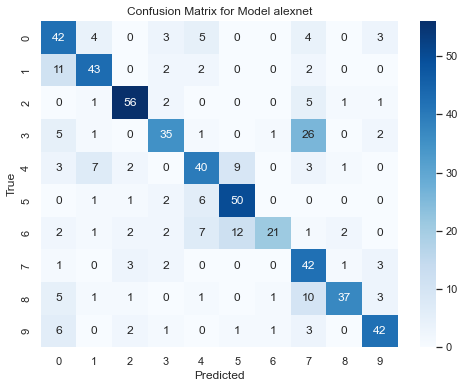

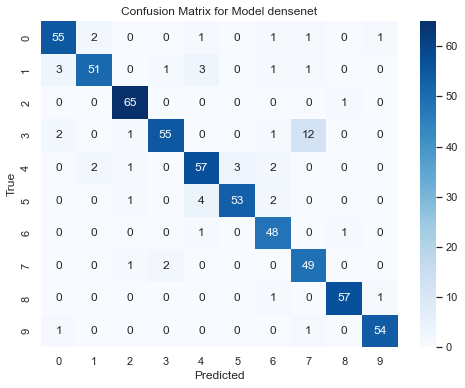

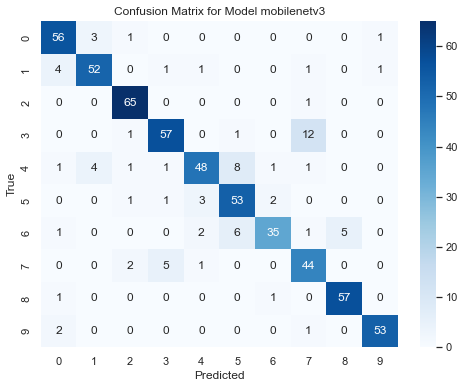

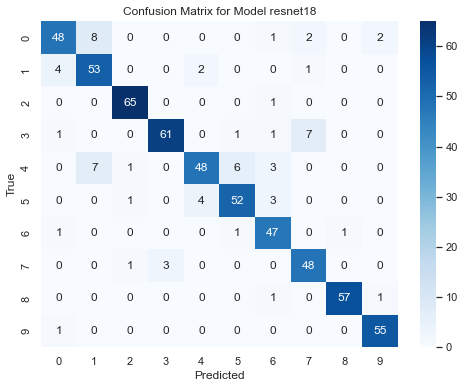

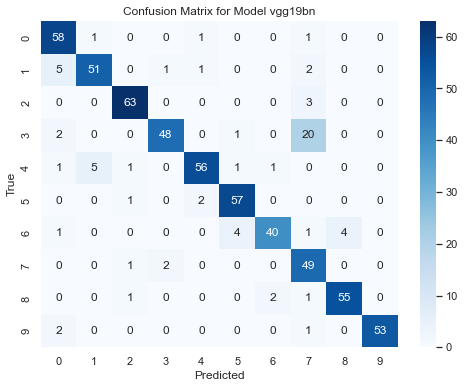

In [88]:
confusion_matrices = []

for true_labels, model_preds in zip(last_true_labels, last_model_preds):
    cm = confusion_matrix(true_labels, model_preds)
    confusion_matrices.append(cm)

for i, cm in enumerate(confusion_matrices):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', 
                xticklabels=np.unique(last_true_labels[i]), 
                yticklabels=np.unique(last_true_labels[i]))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for Model {model_names[i]}')
    plt.show()


#### Accuracies

##### Train Accuracies

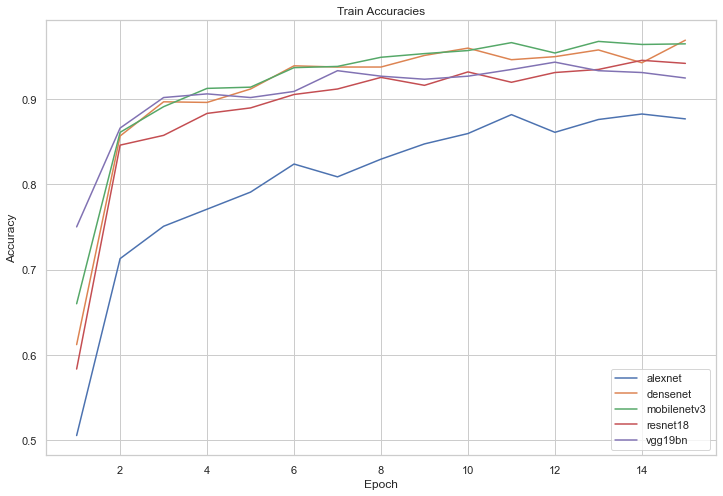

In [89]:
plt.figure(figsize=(12, 8))

for model, accuracies in model_accuracies_dict.items():
    plt.plot(range(1, len(accuracies) + 1), accuracies, label=model)

plt.title('Train Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

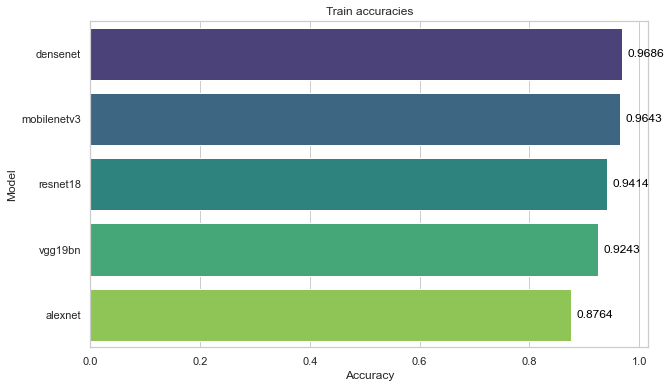

In [90]:
last_accuracies = [accuracies[-1] for accuracies in model_accuracies_dict.values()]
models = list(model_accuracies_dict.keys())

sorted_data = sorted(zip(last_accuracies, models), reverse=True)
sorted_accuracies, sorted_models = zip(*sorted_data)

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

ax = sns.barplot(x=list(sorted_accuracies), y=list(sorted_models), palette='viridis')

for i, v in enumerate(sorted_accuracies):
    ax.text(v + 0.01, i, f'{v:.4f}', color='black', va='center')

plt.title('Train accuracies')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.show()


##### Test Accuracies

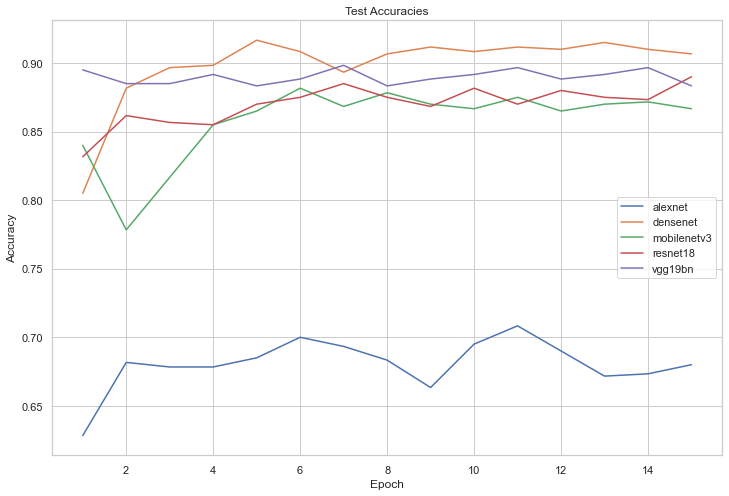

In [91]:
plt.figure(figsize=(12, 8))

for model, accuracies in model_test_accuracies_dict.items():
    plt.plot(range(1, len(accuracies) + 1), accuracies, label=model)

plt.title('Test Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

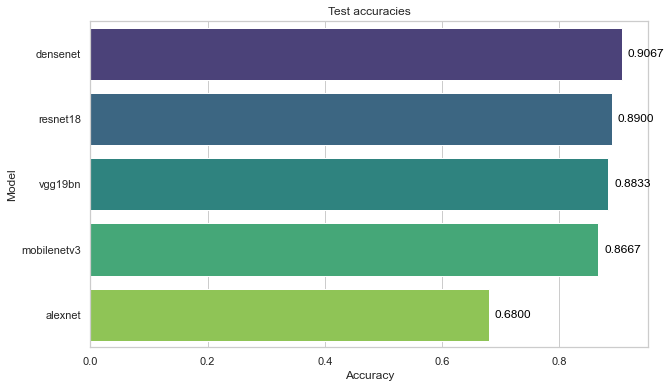

In [92]:
last_accuracies = [accuracies[-1] for accuracies in model_test_accuracies_dict.values()]
models = list(model_test_accuracies_dict.keys())

sorted_data = sorted(zip(last_accuracies, models), reverse=True)
sorted_accuracies, sorted_models = zip(*sorted_data)

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

ax = sns.barplot(x=list(sorted_accuracies), y=list(sorted_models), palette='viridis')

for i, v in enumerate(sorted_accuracies):
    ax.text(v + 0.01, i, f'{v:.4f}', color='black', va='center')

plt.title('Test accuracies')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.show()


##### Train loss

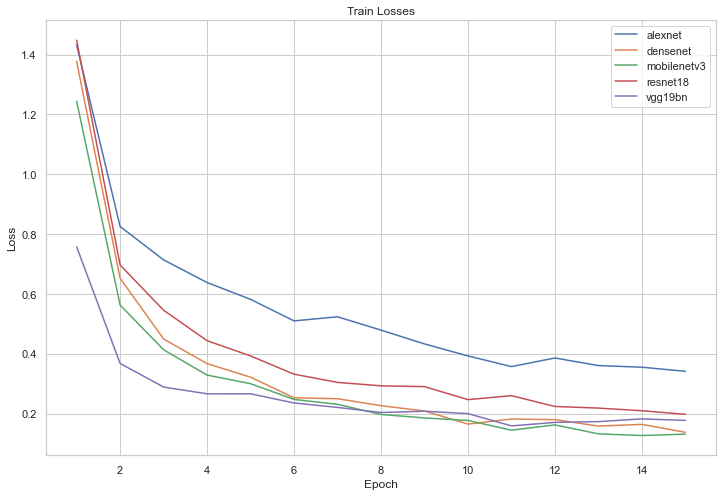

In [93]:
plt.figure(figsize=(12, 8))

for model, accuracies in model_losses_dict.items():
    
    plt.plot(range(1, len(accuracies) + 1), accuracies, label=model)

plt.title('Train Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Test on scrapped dataset cat

In [94]:
class_names = [
    'abyssinian', 'bengal', 'bombay',
    'british_shorthair', 'maine_coon', 'persian',
    'ragdoll', 'russian_blue', 'siamese', 'sphynx'
]

In [95]:
results_directory = 'breed_models/cat/'
all_files = os.listdir(results_directory)
model_files = [file for file in all_files if file.endswith('.pth')]
model_names = [file.split('_')[0] for file in model_files]

  0%|          | 0/55 [00:00<?, ?it/s]

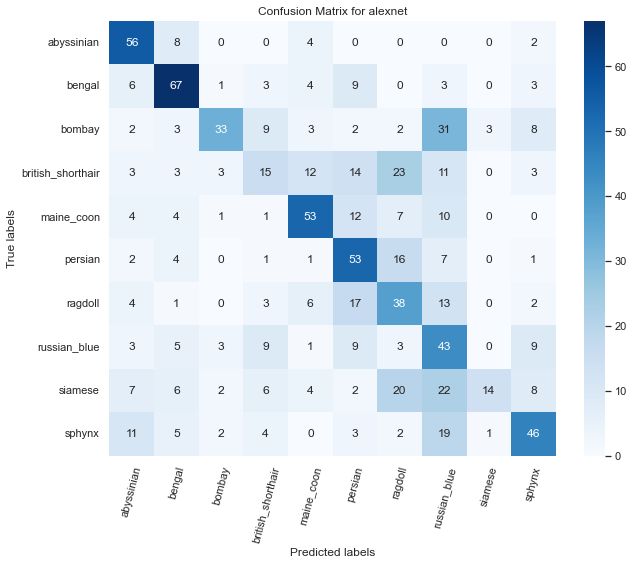

Accuracy: 47.55%


  0%|          | 0/55 [00:00<?, ?it/s]

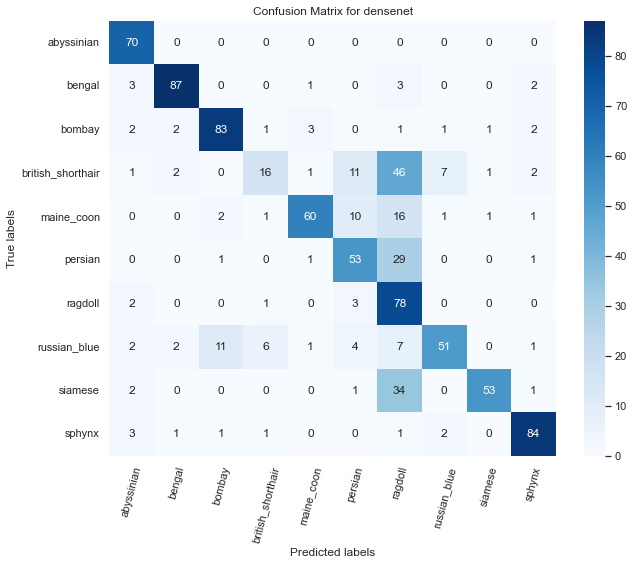

Accuracy: 72.24%


  0%|          | 0/55 [00:00<?, ?it/s]

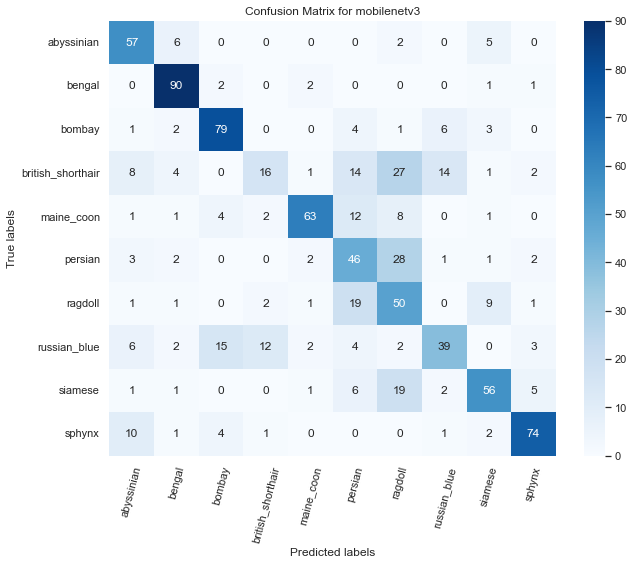

Accuracy: 64.85%


  0%|          | 0/55 [00:00<?, ?it/s]

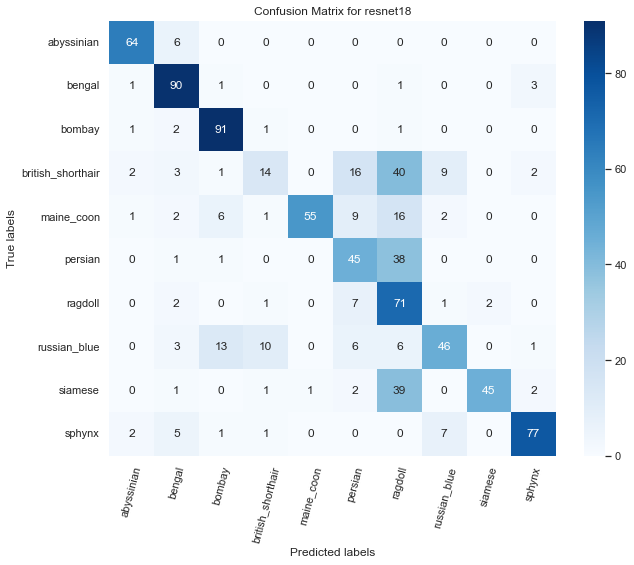

Accuracy: 68.03%


  0%|          | 0/55 [00:00<?, ?it/s]

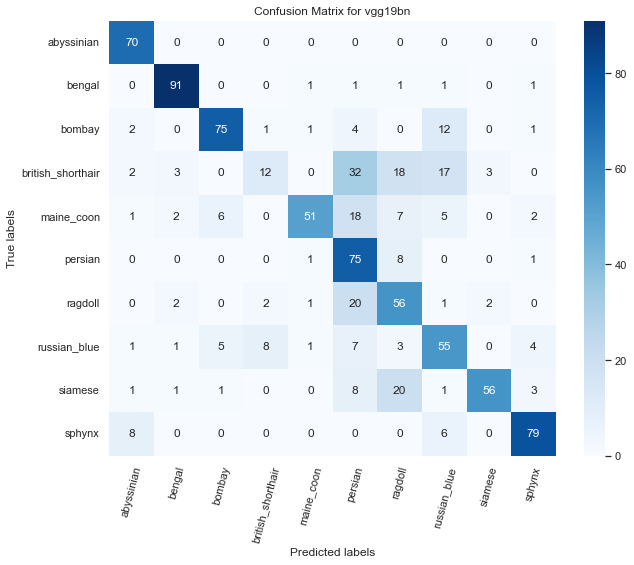

Accuracy: 70.53%


In [97]:
test_data_scrap_cat = ImageFolder('breed_dataset/cat/')
test_transform = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
])
accuracies_scrap = {}
for model_name in model_names:
    state_dict = torch.load(f"breed_models/cat/{model_name}_best_model.pth")
    model = dog_breed.get_pretrained_model(model_name, num_classes)

    model.load_state_dict(state_dict)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    batch_size = 8
    test_dataset_scrap = dog_breed.CatBreedDataset(test_data_scrap_cat, test_transform)
    test_dl_scrap = DataLoader(test_dataset_scrap, batch_size*2)

    confusion_matrix_all_classes = dog_breed.create_confusion_matrix(model, test_dl_scrap)
    dog_breed.plot_confusion_matrix(confusion_matrix_all_classes, class_names, model_name)
    
    total_samples = len(test_dataset_scrap)
    correct_predictions = sum(confusion_matrix_all_classes[i][i] for i in range(len(confusion_matrix_all_classes)))
    accuracy = correct_predictions / total_samples
    accuracies_scrap[model_name] = accuracy
    print(f"Accuracy: {accuracy * 100:.2f}%")



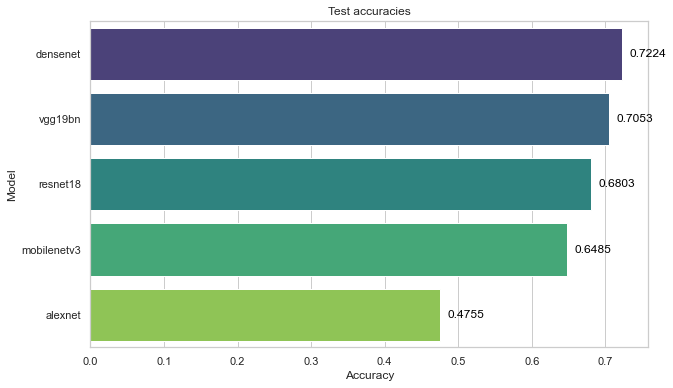

In [98]:
last_accuracies = [accuracies for accuracies in accuracies_scrap.values()]
models = list(accuracies_scrap.keys())

sorted_data = sorted(zip(last_accuracies, models), reverse=True)
sorted_accuracies, sorted_models = zip(*sorted_data)

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

ax = sns.barplot(x=list(sorted_accuracies), y=list(sorted_models), palette='viridis')

for i, v in enumerate(sorted_accuracies):
    ax.text(v + 0.01, i, f'{v:.4f}', color='black', va='center')

plt.title('Test accuracies')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.show()
